# 通し課題の概要
Kickstarter Projects(クラウドファンディングが成功するか否かを予測するコンテスト)のデータセットを利用して、回帰分析を行う。  
https://www.kaggle.com/kemical/kickstarter-projects  
  
予測する対象は、**achievement_rate** : (資金調達の達成率)  
※このコンテストはクラウドファンディングが成功するか否かを予測する分類問題だが、「ドル換算された集まった資金÷ドル換算された資金調達の目標」で算出した資金調達の達成率を予測する回帰問題として扱う。   
achievement_rate =  usd_pledged_real / usd_goal_real  

# 目次
## 0. 通し課題の説明、目的変数の分析
## 1. 全量のデータから直接achievement_rateを予測する
### 1-1 重み 𝑤 と特徴量の線形結合が入力値となるアルゴリズム
・重回帰分析  
・ニューラルネット  
### 1-2 決定木ベースのアルゴリズム
・XGBRegressor

## 2. 分類問題の後、回帰問題として扱う

### 2-1. 資金調達率90%を閾値として、以下のモデルで分類問題を解く
・XGBClassifier  
・AdaBoostClassifier  

### 2-2. 90%未満の場合は、全量データから回帰分析を行う
・重回帰分析  
・ニューラルネット  
・XGBRegressor  
### 2-3. 90%以上の場合は、90%以上のデータから回帰分析を行う
・重回帰分析  
・ニューラルネット   
・XGBRegressor  

ーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー

## 0. 通し課題の説明、目的変数の分析

## 説明変数  
  
**name** : (プロジェクトの名前)  
**category** : (カテゴリー)  
**main_category** : (メインカテゴリー)  
**currency** : (サポートに使用される通貨)  
**deadline** : (クラウドファンディングの締め切り)  
**goal** : (資金調達の目標。クリエイターがプロジェクトを完了するために必要な金額)  各国の通貨  
**launched** : (開始した日時)  
**pledged** : (集まった資金　※各国の通貨単位)  
**backers** : (バッカーの数)  
**country** : (プロジェクトが開かれた国)  
**usd pledged** : (集まった資金の米ドル換算(kickstarterによる変換))  
**usd_pledged_real** : (集まった資金の米ドル換算(Fixer.io APIからの変換))  
**usd_goal_real** : (資金調達の目標。(Fixer.io APIからの変換))  

**※Backer（バッカー）**  
Kickstarter上のアイディアを実現するためにプロジェクトにお金を提供し、支援する人のこと。  
バッカーになることで、希望者はクリエイターによって設けられた、様々なリワードを受け取ることもできる。

## 前提事項
- クラウドファンディング開始後に得るデータは、説明変数として使用しない事とする。
    - pledged : (集まった資金)
    - usd pledged : (集まった資金の米ドル換算(kickstarterによる変換))
    - usd_pledged_real : (集まった資金の米ドル換算(Fixer.io APIからの変換))
    - backers : (バッカーの数)  
- 資金調達の目標は、ドル換算された値「usd_goal_real」を利用するため、ドル換算されていない「goal」は利用しない。

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format

df = pd.read_csv("./datasets/ks-projects-201801.csv", sep=',',parse_dates=['deadline', 'launched'])
display(df.head())

# 目的変数を算出
df['achievement_rate'] = df['usd_pledged_real']*100/df['usd_goal_real']

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00


## 目的変数を可視化する
achievement_rate : (資金調達の達成率)

In [2]:
print(pd.cut(df['achievement_rate'], [0, 100, 1000, 10000, 100000,10000000]).value_counts(normalize=True))

(0, 100]             0.59
(100, 1000]          0.39
(1000, 10000]        0.01
(10000, 100000]      0.00
(100000, 10000000]   0.00
Name: achievement_rate, dtype: float64


In [3]:
print(pd.cut(df['achievement_rate'], range(0,1001,100)).value_counts(normalize=True))

(0, 100]      0.60
(100, 200]    0.33
(200, 300]    0.03
(300, 400]    0.01
(400, 500]    0.01
(500, 600]    0.01
(600, 700]    0.00
(700, 800]    0.00
(800, 900]    0.00
(900, 1000]   0.00
Name: achievement_rate, dtype: float64


achievement_rate : (資金調達の達成率)は、1000%以下の割合が98%ということがわかる。  
また、achievement_rateが0~1000%の範囲で集計すると、200%以下が93%である。  

### achievement_rateが200%以上の値を異常値として、除外する

### achievement_rateが200%以下を可視化する。

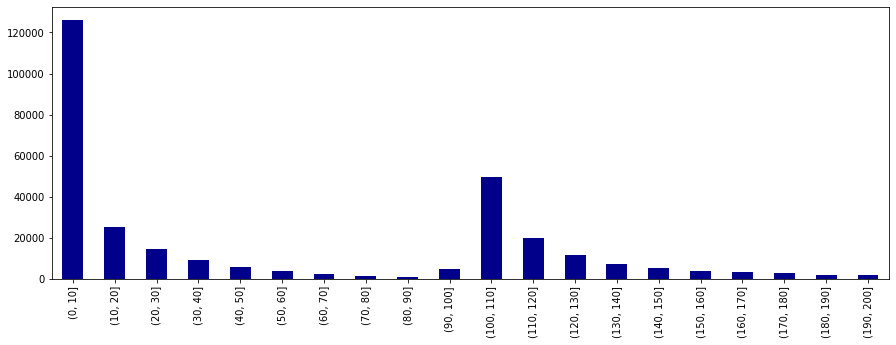

In [4]:
pd.cut(df['achievement_rate'], range(0,201,10)).value_counts(sort=False).plot.bar(figsize=(15,5), color='darkblue')

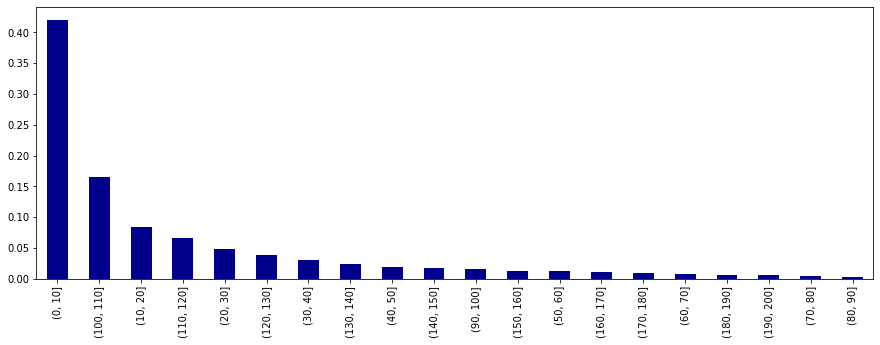

In [5]:
pd.cut(df['achievement_rate'], range(0,201,10)).value_counts(normalize=True).plot.bar(figsize=(15,5), color='darkblue')


[0,10]と[100,110]にデータが集中していることが確認できる。  
また、割合を確認すると  
[0,10]: 42%  
[100,110]:17%  
[10,20]:8%  
[110,220]:7%  

以上の結果から、目的変数を予測する方針を以下の２つとする。
1. 全量のデータから直接achievement_rateを予測する
2. 目的変数が[0,10]付近と[100,110]付近に分かれていることから、それぞれに違った相関がある可能性を踏まえ、２つの山の分類問題を解いて後、それぞれ回帰分析を行う。

## 1. 全量のデータから直接achievement_rateを予測する
### 1-1 重み 𝑤 と特徴量の線形結合が入力値となるアルゴリズム
・重回帰  
・ニューラルネット  
### 1-2 決定木ベースのアルゴリズム
・XGBRegressor

### データの読み込み、前処理
線形結合系のアルゴリズムと決定木ベースのアルゴリズムでは、カテゴリ変数の前処理が異なるため、以下の前処理をする。  
・線形結合モデル→カテゴリ変数をOne Hot Encoding  
・決定木ベース→カテゴリ変数をLabelEncoding  
それ以外の前処理は同じものを行う。  

In [6]:
# 共通部分
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
pd.options.display.float_format = '{:.2f}'.format

#データの読み込み
df = pd.read_csv("./datasets/ks-projects-201801.csv", sep=',',parse_dates=['deadline', 'launched'])

# 目的変数を算出
df['achievement_rate'] = df['usd_pledged_real']*100/df['usd_goal_real']

# 必要のないデータをドロップ
df = df.drop(['pledged','usd pledged','usd_pledged_real','goal','backers','state','name'], axis=1)

# 異常値除外
df = df[df['achievement_rate']<200]

# 全データのうち、20%をテストデータにする
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1234) 

# main_category
grouped_main_category = df_train.groupby('main_category')
Statistics_main_category = grouped_main_category.describe()['achievement_rate']

# category
grouped_category = df_train.groupby('category')
Statistics_category = grouped_category.describe()['achievement_rate']

#currency
grouped_currency = df_train.groupby('currency')
Statistics_currency = grouped_currency.describe()['achievement_rate']

#country
grouped_country = df_train.groupby('country')
Statistics_country = grouped_country.describe()['achievement_rate']

# 基礎統計情報を結合
df_merged_train  = pd.merge(df_train,Statistics_main_category, how='inner', left_on='main_category', right_index=True, suffixes=['', 'main_category'])
df_merged_train  = pd.merge(df_merged_train,Statistics_category, how='inner', left_on='category', right_index=True, suffixes=['', '_category'])
df_merged_train  = pd.merge(df_merged_train,Statistics_currency, how='inner', left_on='currency', right_index=True, suffixes=['', '_currency'])
df_merged_train  = pd.merge(df_merged_train,Statistics_country, how='inner', left_on='country', right_index=True, suffixes=['', '_country'])

df_merged_test  = pd.merge(df_test,Statistics_main_category, how='inner', left_on='main_category', right_index=True, suffixes=['', 'main_category'])
df_merged_test  = pd.merge(df_merged_test,Statistics_category, how='inner', left_on='category', right_index=True, suffixes=['', '_category'])
df_merged_test  = pd.merge(df_merged_test,Statistics_currency, how='inner', left_on='currency', right_index=True, suffixes=['', '_currency'])
df_merged_test  = pd.merge(df_merged_test,Statistics_country, how='inner', left_on='country', right_index=True, suffixes=['', '_country'])

# dropするカラム
drop_columns = ['ID','deadline','launched'
                                    ,'min','max','count','50%','75%'
                                    ,'min_category','max_category' ,'count_category','50%_category','75%_category'
                                    ,'min_currency','max_currency' ,'count_currency','50%_currency','75%_currency'
                                    ,'min_country','max_country' ,'count_country','50%_country','75%_country']
df_merged_train = df_merged_train.drop(drop_columns, axis=1)
df_merged_test = df_merged_test.drop(drop_columns, axis=1)

# 欠損値を除外する。
df_merged_train = df_merged_train.dropna()
df_merged_test = df_merged_test.dropna()

In [7]:
# 線形結合系
df_merged_train_liner = df_merged_train.copy(deep=True)
df_merged_test_liner = df_merged_test.copy(deep=True)

# One Hot Encoding
# main_category、category、country、currencyはダミー変数を取得する。
df_merged_train_liner = pd.get_dummies(df_merged_train_liner, drop_first=True)
df_merged_test_liner = pd.get_dummies(df_merged_test_liner, drop_first=True)
    
X_train_liner = df_merged_train_liner.drop(['achievement_rate'], axis=1).values
y_train_liner = df_merged_train_liner['achievement_rate'].values
X_test_liner = df_merged_test_liner.drop(['achievement_rate'], axis=1).values
y_test_liner = df_merged_test_liner['achievement_rate'].values

In [8]:
# 決定木ベース

# LabelEncoding
categorical_feats = df_merged_train.dtypes[df_merged_train.dtypes == "object"].index
le = LabelEncoder()
for feat in categorical_feats:
    df_merged_train[feat] = le.fit_transform(df_merged_train[feat])
    df_merged_test[feat] = le.fit_transform(df_merged_test[feat])

X_train = df_merged_train.drop(['achievement_rate'], axis=1).values
y_train = df_merged_train['achievement_rate'].values
X_test = df_merged_test.drop(['achievement_rate'], axis=1).values
y_test = df_merged_test['achievement_rate'].values

In [9]:
# 予測結果の上限と下限
MAX_SCORE = 300
MIN_SCORE = 0

### 1-1-1. 重回帰モデル

In [10]:
# 学習用データを使って線形回帰モデルを学習
regr = LinearRegression(fit_intercept=True)
regr.fit(X_train_liner, y_train_liner)

# 学習用データに対する予測を実行
y_pred_train = regr.predict(X_train_liner)
y_pred_train = np.clip(y_pred_train,MIN_SCORE,MAX_SCORE)
print("学習データに対する誤差")

# MSEを計算
mse = mean_squared_error(y_train_liner, y_pred_train) 
print("MSE = %s"%round(mse,3) )  
# MAEを計算
mae = mean_absolute_error(y_train_liner, y_pred_train) 
print("MAE = %s"%round(mae,3) )
# RMSEを計算
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )
# 決定係数R^2を計算
r2 = r2_score(y_train_liner, y_pred_train) 
print("R^2 = %s"%round(r2, 3))

# テストデータに対する予測を実行
y_pred_test = regr.predict(X_test_liner)
y_pred_test = np.clip(y_pred_test,MIN_SCORE,MAX_SCORE)

print("予測データに対する誤差")

# MSEを計算
mse = mean_squared_error(y_test_liner, y_pred_test) 
print("MSE = %s"%round(mse,3) )  
# MAEを計算
mae = mean_absolute_error(y_test_liner, y_pred_test) 
print("MAE = %s"%round(mae,3) )
# RMSEを計算
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )
# 決定係数R^2を計算
r2 = r2_score(y_test_liner, y_pred_test) 
print("R^2 = %s"%round(r2, 3))

学習データに対する誤差
MSE = 2674.433
MAE = 44.292
RMSE = 51.715
R^2 = 0.099
予測データに対する誤差
MSE = 2674.507
MAE = 44.303
RMSE = 51.716
R^2 = 0.097


### 1-1-2. ニューラルネットワーク

In [11]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

model = MLPRegressor(hidden_layer_sizes=(100,100,100,100,),random_state=42,early_stopping=True)
model.fit(X_train_liner, y_train_liner)

y_pred_train = model.predict(X_train_liner)
y_pred_train = np.clip(y_pred_train,MIN_SCORE,MAX_SCORE)

y_pred_test = model.predict(X_test_liner)
y_pred_test = np.clip(y_pred_test,MIN_SCORE,MAX_SCORE)

print("学習データに対する誤差")
# MSEを計算
mse = mean_squared_error(y_train_liner, y_pred_train) 
print("MSE = %s"%round(mse,3) )  
# MAEを計算
mae = mean_absolute_error(y_train_liner, y_pred_train) 
print("MAE = %s"%round(mae,3) )
# RMSEを計算
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )
# 決定係数R^2を計算
r2 = r2_score(y_train_liner, y_pred_train) 
print("R^2 = %s"%round(r2, 3))

print("予測データに対する誤差")

# MSEを計算
mse = mean_squared_error(y_test_liner, y_pred_test) 
print("MSE = %s"%round(mse,3) )  
# MAEを計算
mae = mean_absolute_error(y_test_liner, y_pred_test) 
print("MAE = %s"%round(mae,3) )
# RMSEを計算
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )
# 決定係数R^2を計算
r2 = r2_score(y_test_liner, y_pred_test) 
print("R^2 = %s"%round(r2, 3))

学習データに対する誤差
MSE = 2559.031
MAE = 42.431
RMSE = 50.587
R^2 = 0.138
予測データに対する誤差
MSE = 2562.72
MAE = 42.495
RMSE = 50.623
R^2 = 0.135


### 1-2 決定木ベースのアルゴリズム
・XGBClassifier  

パラメータはベイズ最適化を用いて事前に算出済み。  

In [ ]:
from bayes_opt import BayesianOptimization

# BayesianOptimizationで最適化を行う関数を定義
# 調整を行うハイパーパラメータを引数として持ち、モデル訓練とテストデータを使った推測値を算出して、最後に正解率の値を戻す関数
def xgb_evaluate(min_child_weight, subsample, colsample_bytree, max_depth):
    params = {
              'objective':'reg:squarederror',
              'n_estimators':500,
              'random_state':1234,
              'boosting_type':'gbdt',
              'learning_rate':0.01j,              
              'min_child_weight': int(min_child_weight),
              'max_depth': int(max_depth),
              'colsample_bytree': colsample_bytree,
              'subsample': subsample,
             }
    reg = xgb.XGBRegressor()
    reg.set_params(**params)
    reg.fit(X_train,
            y_train,
            early_stopping_rounds=50,
            eval_set=[(X_test, y_test)],
            eval_metric='error',
            verbose=0)
    
    pred_test = reg.predict(X_test)
    score = -1 * mean_squared_error(y_test, pred_test)
    return score

In [ ]:
# ベイズ最適化ではxgb_evaluate関数が戻すscore（正解率の値）の最大化を目的としてハイパーパラメータの値を探索する。
# 4つのハイパーパラメータに絞り、候補の値をBayesianOptimizationのクラスへ渡す。
# min_child_weight:(1, 20)と記載がありますが、これはmin_child_weightのハイパーパラメータへ1から20に属する値を候補の値として探索することを示す。
xgb_bo = BayesianOptimization(xgb_evaluate, 
                              {'min_child_weight': (1,20),
                               'subsample': (.1,1),
                               'colsample_bytree': (.1,1),
                               'max_depth': (1,20)},
                              random_state=1234)

xgb_bo.maximize(init_points=10, n_iter=30, acq='ei')

# 最も評価スコアが高かった結果をmax属性より取得
# ベイズ最適化により得られた最もスコアの良かったハイパーパラメータの値を変数optimized_paramsへ格納
optimized_params = xgb_bo.max['params']
optimized_params['max_depth'] = int(optimized_params['max_depth'])
optimized_params

In [12]:
import xgboost as xgb

optimized_params = {'colsample_bytree': 0.7044496095009221,
                                     'max_depth': 18,
                                     'min_child_weight': 8.461780922956077,
                                     'subsample': 0.653290647776272}
fixed_params = {
              'objective':'reg:squarederror',
              'n_estimators':500,
              'random_state':1234,
              'learning_rate':0.01}

# xgboostモデルの作成
xgbReg = xgb.XGBRegressor()
xgbReg.set_params(**fixed_params, **optimized_params)
xgbReg.fit(X_train,
        y_train,
        early_stopping_rounds=50,
        eval_set=[(X_test, y_test)],
        eval_metric='error',
        verbose=0)

# 評価
y_pred_train = xgbReg.predict(X_train)
y_pred_train = np.clip(y_pred_train,MIN_SCORE,MAX_SCORE)
y_pred_test = xgbReg.predict(X_test)
y_pred_test = np.clip(y_pred_test,MIN_SCORE,MAX_SCORE)

print("学習データに対する誤差")
# MSEを計算
mse = mean_squared_error(y_train, y_pred_train) 
print("MSE = %s"%round(mse,3) )  
# MAEを計算
mae = mean_absolute_error(y_train, y_pred_train) 
print("MAE = %s"%round(mae,3) )
# RMSEを計算
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )
# 決定係数R^2を計算
r2 = r2_score(y_train, y_pred_train) 
print("R^2 = %s"%round(r2, 3))

print("予測データに対する誤差")

# MSEを計算
mse = mean_squared_error(y_test, y_pred_test) 
print("MSE = %s"%round(mse,3) )  
# MAEを計算
mae = mean_absolute_error(y_test, y_pred_test) 
print("MAE = %s"%round(mae,3) )
# RMSEを計算
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )
# 決定係数R^2を計算
r2 = r2_score(y_test, y_pred_test) 
print("R^2 = %s"%round(r2, 3))

学習データに対する誤差
MSE = 2475.253
MAE = 39.751
RMSE = 49.752
R^2 = 0.166
予測データに対する誤差
MSE = 2633.325
MAE = 41.142
RMSE = 51.316
R^2 = 0.111


## 汎化誤差を比較した結果

| model            | MSE  | MAE  | RMSE | R^2   |
|------------------|------|------|------|-------|
| LinearRegression | 2675 | 44.3 | 51.7 | 0.097 |
| MLPRegressor     | 2562 | 42.4 | 50.6 | 0.135 |
| XGBRegressor     | 2633 | 41.1 | 51.3 | 0.111 |


汎化誤差の評価指標であるMSE、MAE、RMSE、R^2の各モデルで比較した。  
評価指標を確認する限り、各モデルに差はなく、また、R^2が役0.1であることから、あまり精度が良いモデルとはいえないことがわかった。  
また、評価指標だけでは、各モデルの特徴（予測精度が良い部分や悪い部分）がわからないため、予測結果とその誤差をより詳細に分析する。  

In [13]:
df_compare_result = df_merged_test.copy(deep=True)
df_compare_result = df_compare_result[['achievement_rate']]
# 各モデルの予測結果
df_compare_result['LinearRegression'] = np.clip(regr.predict(X_test_liner),MIN_SCORE,MAX_SCORE)
df_compare_result['MLPRegressor'] = np.clip(model.predict(X_test_liner),MIN_SCORE,MAX_SCORE)
df_compare_result['XGBRegressor'] = np.clip(xgbReg.predict(X_test),MIN_SCORE,MAX_SCORE)
# 各モデルの予測誤差
df_compare_result['LinearRegressionError'] = abs(df_compare_result['achievement_rate'] - df_compare_result['LinearRegression'])
df_compare_result['MLPRegressorError'] = abs(df_compare_result['achievement_rate'] - df_compare_result['MLPRegressor'])
df_compare_result['XGBRegressorError'] = abs(df_compare_result['achievement_rate'] - df_compare_result['XGBRegressor'])
# 各モデルの予測誤差率
df_compare_result['achievement_rate_for_divide'] = df_compare_result['achievement_rate']+1
df_compare_result['LinearRegressionErrorRate'] = df_compare_result['LinearRegressionError']/df_compare_result['achievement_rate_for_divide'] *100
df_compare_result['MLPRegressorErrorRate'] = df_compare_result['MLPRegressorError']/df_compare_result['achievement_rate_for_divide'] *100
df_compare_result['XGBRegressorErrorRate'] = df_compare_result['XGBRegressorError']/df_compare_result['achievement_rate_for_divide'] *100
# 正解を0~200で10区切りに分類し、各モデルの予測誤差を取得
df_compare_result['key'] = pd.cut(df_compare_result['achievement_rate'], range(0,201,10), right=False)
df_compare_LR = df_compare_result.pivot(columns='key', values='LinearRegression')
df_compare_MR = df_compare_result.pivot(columns='key', values='MLPRegressor')
df_compare_XR = df_compare_result.pivot(columns='key', values='XGBRegressor')
df_compare_LR_error = df_compare_result.pivot(columns='key', values='LinearRegressionError')
df_compare_MR_error = df_compare_result.pivot(columns='key', values='MLPRegressorError')
df_compare_XR_error = df_compare_result.pivot(columns='key', values='XGBRegressorError')

### 各モデルの特徴を視覚化する
横軸が正解値（0~200%を10%区切りに分類した）  
縦軸が予測誤差{（予測値-正解値）の絶対値}  

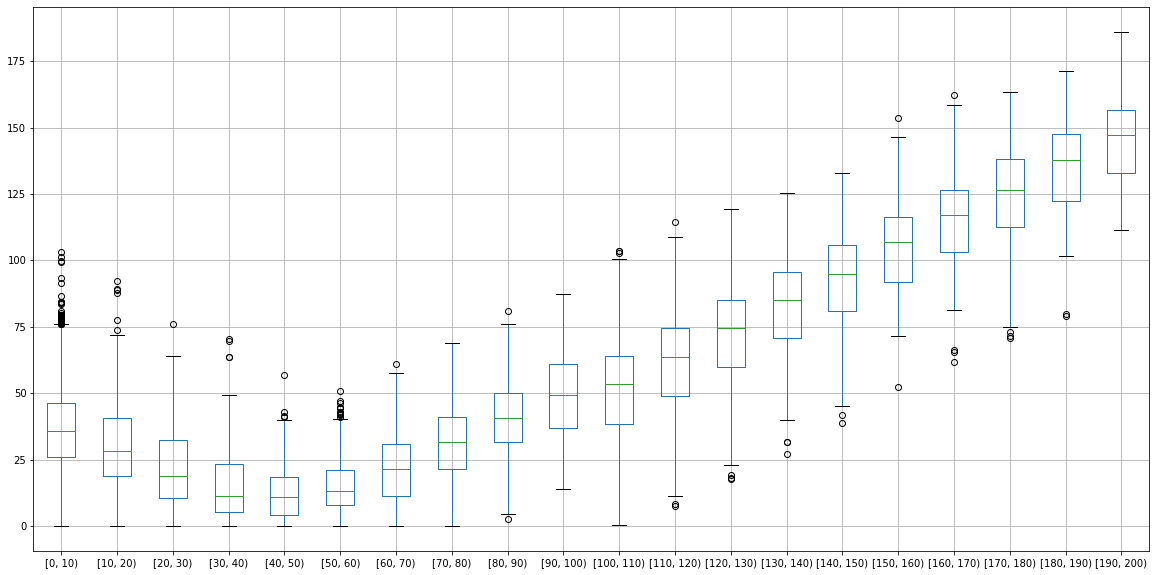

In [14]:
# 重回帰分析
df_compare_LR_error.boxplot(figsize=(20,10))

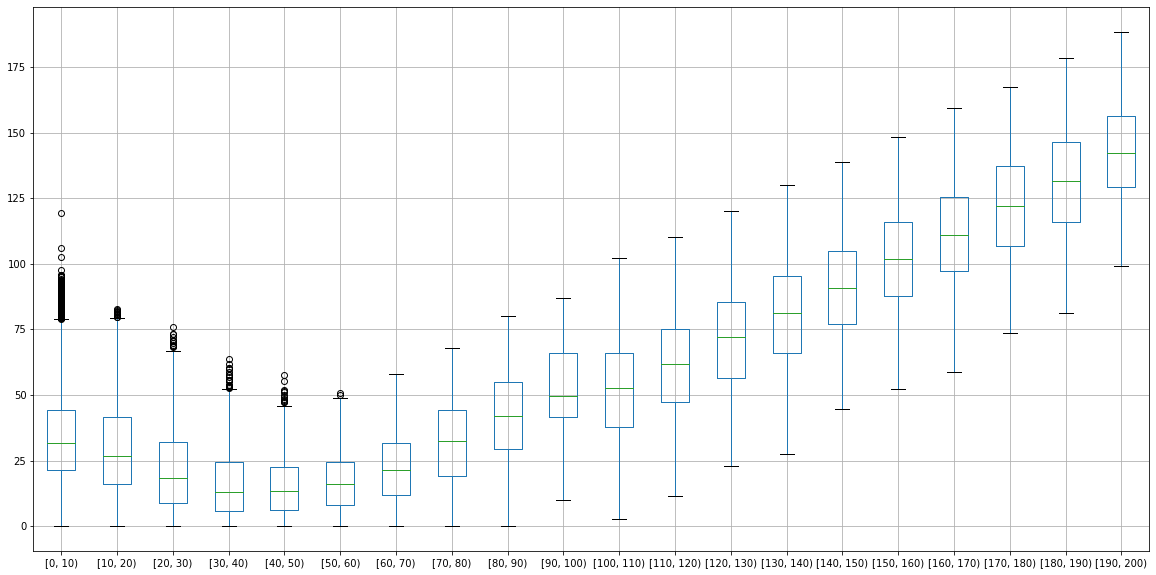

In [15]:
# ニューラルネットワーク
df_compare_MR_error.boxplot(figsize=(20,10))

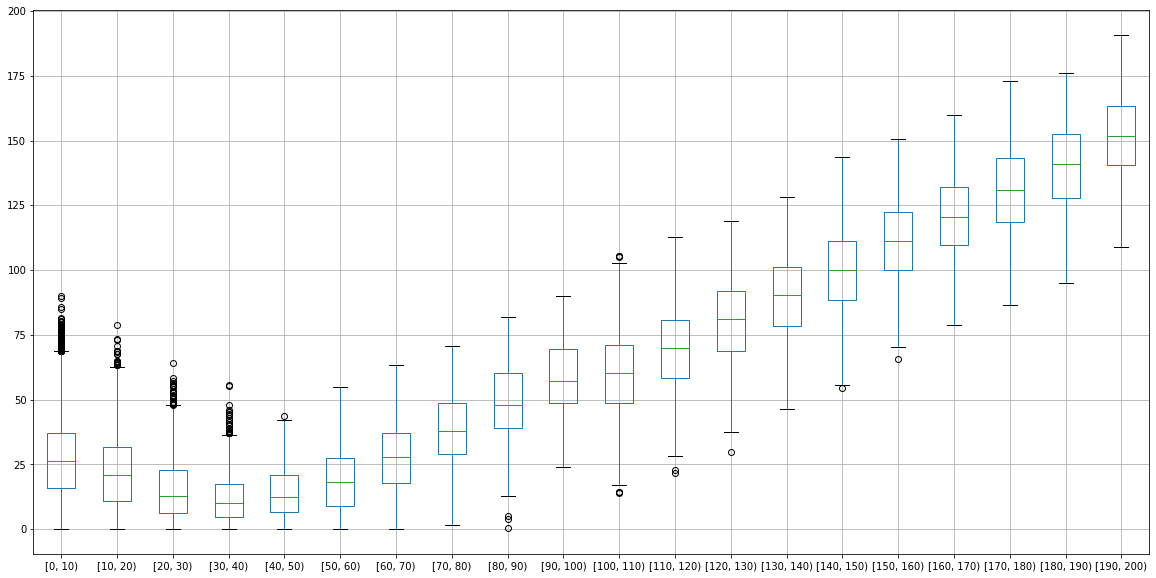

In [16]:
# 勾配ブースティング決定木
df_compare_XR_error.boxplot(figsize=(20,10))

### 予測誤差を視覚化した結果
重回帰モデルは、資金調達率が40%,50%付近の予測精度がよく、また、資金調達率が上がるにつれて誤差が大きくなっている。  
ニューラルネットワークは、資金調達率が30%,60%の間では、75%の割合が誤差25未満である。また、資金調達率が上がるにつれて誤差が大きくなっている。  
勾配ブースティング決定木は、資金調達率が20%,50%の間では、75%の割合が誤差25未満である。また、資金調達率が上がるにつれて誤差が大きくなっている。  
また、資金調達率が0~20%付近の精度が比較的良い。  

各モデルに共通していることは、資金調達率が上がるにつれて、誤差が大きくなっていることである。   
次に、予測値と正解値の関係を視覚化してみる。  

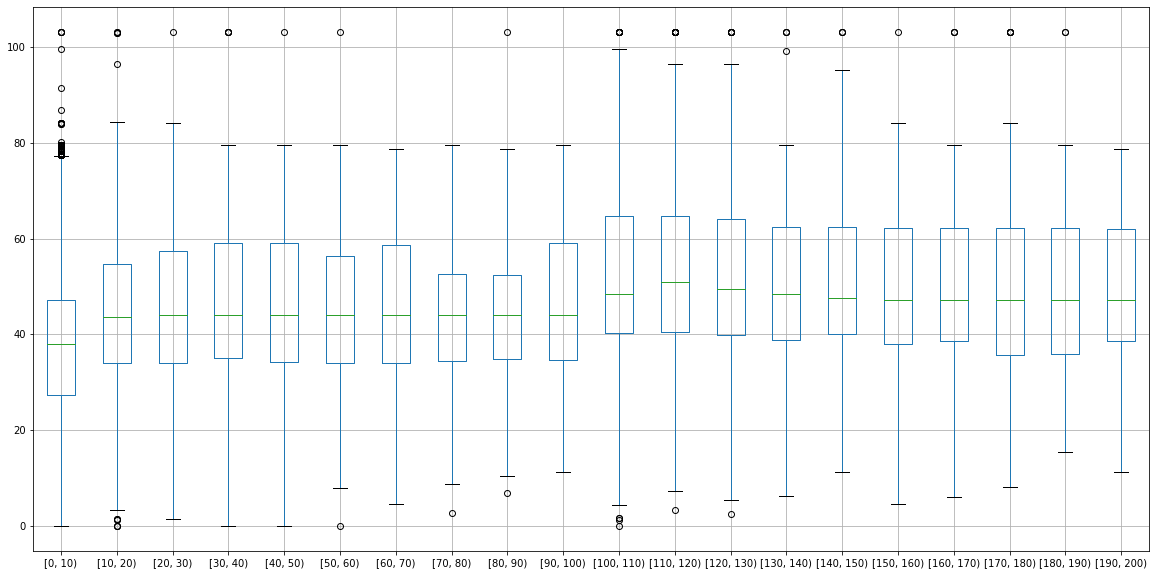

In [17]:
# 重回帰分析
df_compare_LR.boxplot(figsize=(20,10))

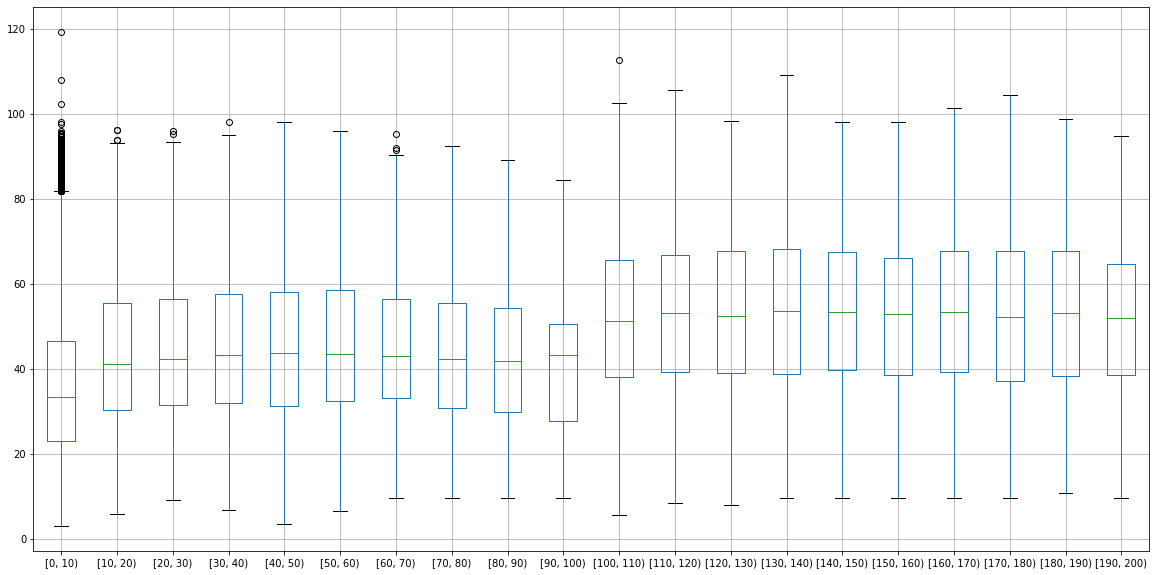

In [18]:
# ニューラルネットワーク
df_compare_MR.boxplot(figsize=(20,10))

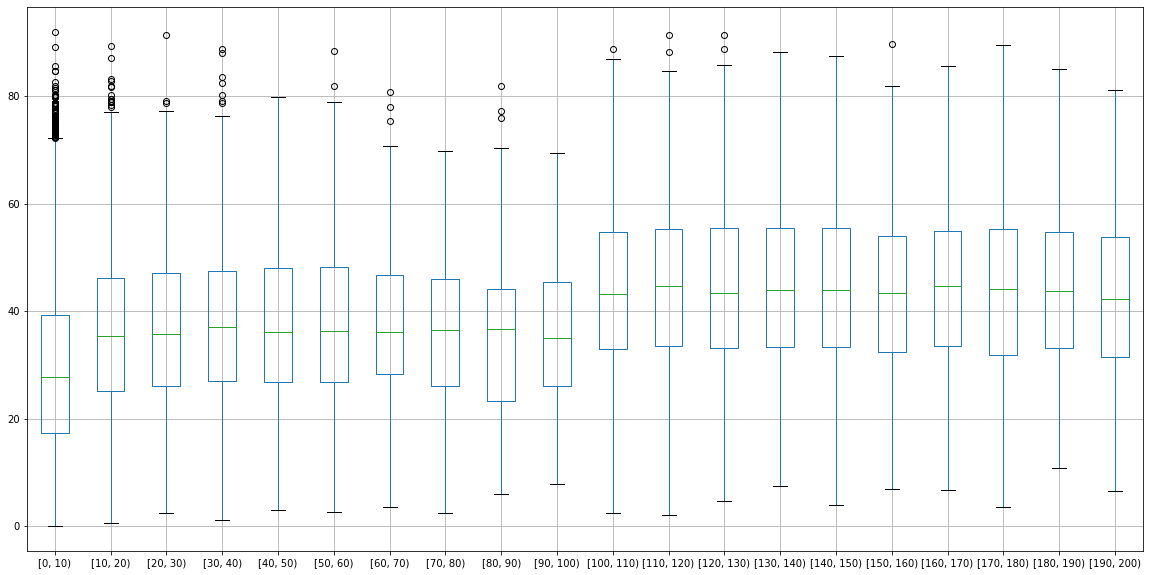

In [19]:
# 勾配ブースティング決定木
df_compare_XR.boxplot(figsize=(20,10))

### 予測値と正解値の関係を視覚化した結果
各モデルの予測値と正解値の関係を視覚化した結果、若干の右肩上がりではあるが、ほぼフラットな結果が得られた。  
全てのモデルにおいて同様の結果が得られたため、学習データに資金調達率が上がる要因を含めることができていない可能性がある。  

## 2. 分類問題の後、回帰問題として扱う

### 2-1. 資金調達率90%を閾値として、以下のモデルで分類問題を解く
・XGBClassifier  
・AdaBoostClassifier  

### 2-2. 90%未満の場合は、全量データから回帰分析を行う
### 2-3. 90%以上の場合は、90%以上のデータから回帰分析を行う

In [20]:
# 決定木ベース
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# １次目的変数を作成(achievement_typeは、achievement_rateが90未満の場合0、それ以外の場合1) 
df_merged_train['achievement_type'] = df_merged_train['achievement_rate'].apply(lambda x : 0 if x < 90 else 1)
df_merged_test['achievement_type'] = df_merged_test['achievement_rate'].apply(lambda x : 0 if x < 90 else 1)

X_train = df_merged_train.drop(['achievement_rate','achievement_type'], axis=1).values
y_train = df_merged_train['achievement_type'].values
X_test = df_merged_test.drop(['achievement_rate','achievement_type'], axis=1).values
y_test = df_merged_test['achievement_type'].values

In [21]:
optimized_params ={'colsample_bytree': 0.95942280432701,
 'max_depth': 16,
 'min_child_weight': 6.633355432919109,
 'subsample': 0.13641935098074606}

fixed_params = {
                'objective':'binary:logistic',
                'n_estimators':500,
                'random_state':1234,
                'learning_rate':0.01}

fixcls = xgb.XGBClassifier()
fixcls.set_params(**fixed_params, **optimized_params)
fixcls.fit(X_train,
        y_train,
        early_stopping_rounds=50,
        eval_set=[(X_test, y_test)],
        eval_metric='error')

[0]	validation_0-error:0.29744
Will train until validation_0-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.29191
[2]	validation_0-error:0.29016
[3]	validation_0-error:0.28931
[4]	validation_0-error:0.28747
[5]	validation_0-error:0.28727
[6]	validation_0-error:0.28717
[7]	validation_0-error:0.28578
[8]	validation_0-error:0.28578
[9]	validation_0-error:0.28517
[10]	validation_0-error:0.28508
[11]	validation_0-error:0.28479
[12]	validation_0-error:0.28450
[13]	validation_0-error:0.28428
[14]	validation_0-error:0.28409
[15]	validation_0-error:0.28443
[16]	validation_0-error:0.28399
[17]	validation_0-error:0.28395
[18]	validation_0-error:0.28388
[19]	validation_0-error:0.28381
[20]	validation_0-error:0.28379
[21]	validation_0-error:0.28413
[22]	validation_0-error:0.28362
[23]	validation_0-error:0.28381
[24]	validation_0-error:0.28372
[25]	validation_0-error:0.28321
[26]	validation_0-error:0.28333
[27]	validation_0-error:0.28344
[28]	validation_0-error:0.28323
[29]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.95942280432701, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=16,
              min_child_weight=6.633355432919109, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic',
              random_state=1234, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.13641935098074606, tree_method='exact',
              validate_parameters=1, verbosity=None)

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-0pky" colspan="2" rowspan="2"></th>
    <th class="tg-0pky" colspan="2">機械学習モデルの予測</th>
  </tr>
  <tr>
    <td class="tg-0pky">Positive</td>
    <td class="tg-0pky">Negative</td>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0pky" rowspan="2">実際のクラス</td>
    <td class="tg-0pky">Positive</td>
    <td class="tg-0pky">TP</td>
    <td class="tg-0pky">FN</td>
  </tr>
  <tr>
    <td class="tg-0pky">Negative</td>
    <td class="tg-0pky">FP</td>
    <td class="tg-0pky">NN</td>
  </tr>
</tbody>
</table>

In [22]:
print('best score : ', fixcls.best_score)
print('best iter : ', fixcls.best_iteration)

pred_af_bay = fixcls.predict(X_test)
print("ベイズ最適化後の正解率　：　{}%".format(accuracy_score(y_test, pred_af_bay)*100))
print(confusion_matrix(y_test, pred_af_bay))

best score :  0.282603
best iter :  66
ベイズ最適化後の正解率　：　71.73974700777129%
[[43499  4716]
 [15212  7089]]


In [23]:
adaClf = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini', max_depth=2, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort='deprecated', random_state=None, splitter='best'), learning_rate=0.5, n_estimators=50, random_state=None)
adaClf.fit(X_train, y_train)
pred_ada = adaClf.predict(X_test)
print("正解率　：　{}%".format(accuracy_score(y_test, pred_ada)*100))
print(confusion_matrix(y_test, pred_ada))

正解率　：　71.48590390833286%
[[43497  4718]
 [15389  6912]]


### 2-1.資金調達率90%を閾値として、以下のモデルで分類問題を解いた結果
・XGBClassifierの正答率は71.7%  
・AdaBoostClassifierの正答率は71.4%  
それぞれ７割の正答率となった。
お互いの正答率が近い理由は、それぞれ決定木をベースとした、ブースティングのモデルだからと考えられる。  
次に、それぞれのモデルが正しく分類できたデータ、誤分類したデータを、資金調達率の軸で分析する。

In [24]:
# 分類結果を視覚化する
df_compare1 = df_merged_test[['achievement_type','achievement_rate']].copy(deep=True)
# 予測結果
df_compare1['XGBClassifier'] = pred_af_bay
df_compare1['AdaBoostClassifier'] = pred_ada
# 正解と予測結果が一致する場合はTrue、不一致の場合はFalse
df_compare1['XGBClassifierTrueFalse'] = (df_compare1['achievement_type']==df_compare1['XGBClassifier'])
df_compare1['AdaBoostClassifierTrueFalse'] = (df_compare1['achievement_type']==df_compare1['AdaBoostClassifier'])
# achievement_rateを0,200を10ずつ分割して比較
df_compare1['key'] = pd.cut(df_compare1['achievement_rate'], range(0,201,10), right=False) 
df_compare_XGBClassifier = df_compare1[['key','XGBClassifierTrueFalse']].groupby(['key','XGBClassifierTrueFalse'])
df_compare_AdaBoostClassifier = df_compare1[['key','AdaBoostClassifierTrueFalse']].groupby(['key','AdaBoostClassifierTrueFalse'])

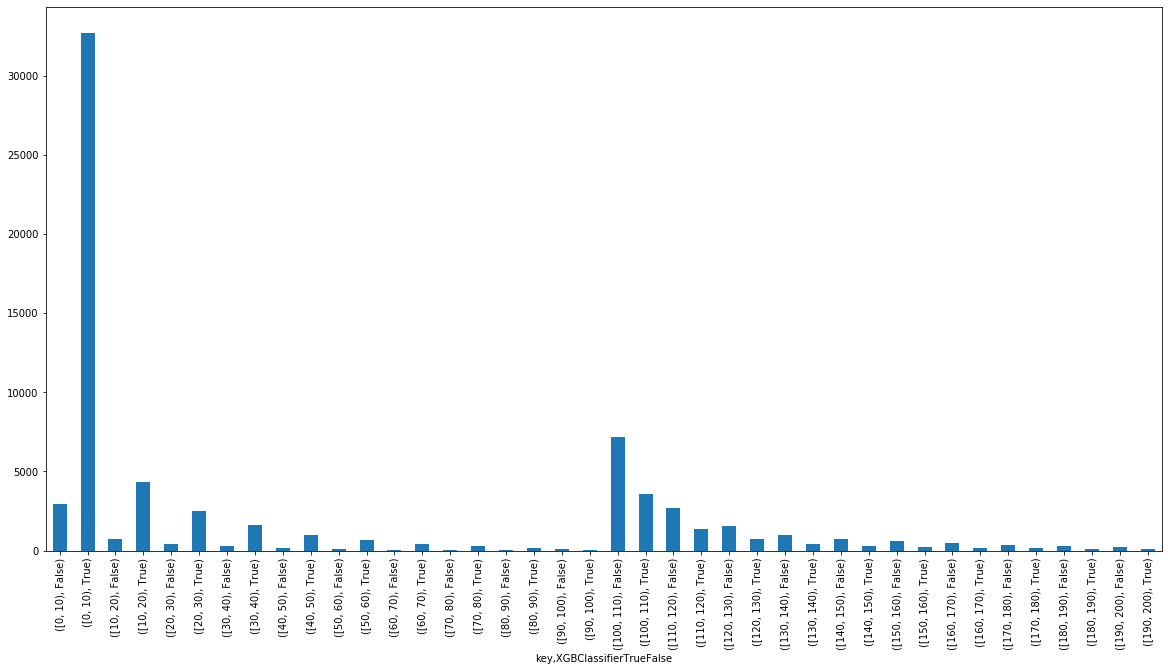

In [25]:
df_compare_XGBClassifier.size().plot.bar(figsize=(20,10))

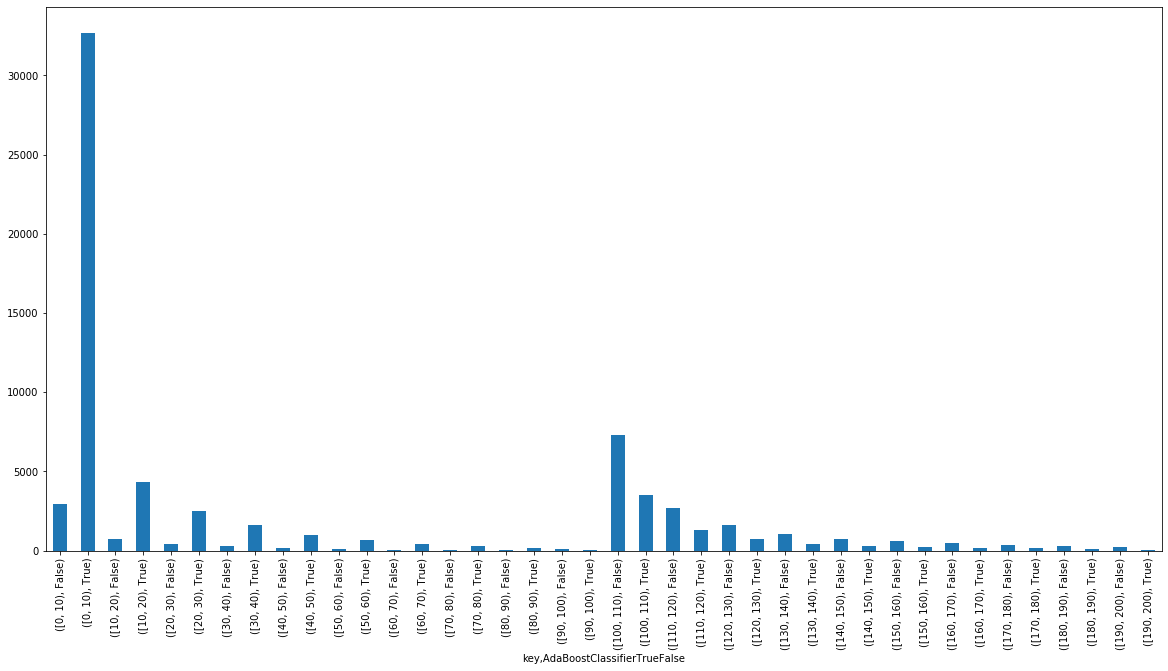

In [26]:
df_compare_AdaBoostClassifier.size().plot.bar(figsize=(20,10))

資金調達率が0,90%においては、分類した結果が正しい割合の方が、誤分類よりも大幅に高い。  
資金調達率が90%以上においては、分類した結果が正正しい割合の方が、誤分類よりも低い。  


In [27]:
df_merged_test['achievement_type'] = pred_af_bay

### 2-2. 90%未満の場合は、全量データから回帰分析を行う
### 2-3. 90%以上の場合は、90%以上のデータから回帰分析を行

In [28]:
# 2-2と2-3用にデータを分割
X_train_under90 = df_merged_train.drop(['achievement_rate','achievement_type'], axis=1).values
y_train_under90 = df_merged_train['achievement_rate'].values
X_test_under90 = df_merged_test[df_merged_test['achievement_type'] == 0].drop(['achievement_rate','achievement_type'], axis=1).values
y_test_under90 = df_merged_test[df_merged_test['achievement_type'] == 0]['achievement_rate'].values
X_train_over90 = df_merged_train[df_merged_train['achievement_type'] == 1].drop(['achievement_rate','achievement_type'], axis=1).values
y_train_over90 = df_merged_train[df_merged_train['achievement_type'] == 1]['achievement_rate'].values
X_test_over90 = df_merged_test[df_merged_test['achievement_type'] == 1].drop(['achievement_rate','achievement_type'], axis=1).values
y_test_over90 = df_merged_test[df_merged_test['achievement_type'] == 1]['achievement_rate'].values

X_trains = [X_train_under90,X_train_over90]
X_tests = [X_test_under90,X_test_over90]
y_trains = [y_train_under90,y_train_over90]
y_tests = [y_test_under90,y_test_over90]

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import r2_score

MIN_SCORES = [0,0]
MAX_SCORES = [90,200]

for X_train,X_test,y_train,y_test,min_score,max_score in zip(X_trains,X_tests,y_trains,y_tests,MIN_SCORES,MAX_SCORES):

    # 学習用データを使って線形回帰モデルを学習
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)

    # 学習用データに対する予測を実行
    y_pred_train = regr.predict(X_train)
    y_pred_train = np.clip(y_pred_train,min_score,max_score)
    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)
    y_pred_test = np.clip(y_pred_test,min_score,max_score)

    print("学習データに対する誤差")

    # MSEを計算
    mse = mean_squared_error(y_train, y_pred_train) 
    print("MSE = %s"%round(mse,3) )  
    # MAEを計算
    mae = mean_absolute_error(y_train, y_pred_train) 
    print("MAE = %s"%round(mae,3) )
    # RMSEを計算
    rmse = np.sqrt(mse)
    print("RMSE = %s"%round(rmse, 3) )
    # 決定係数R^2を計算
    r2 = r2_score(y_train, y_pred_train) 
    print("R^2 = %s"%round(r2, 3))

    print("予測データに対する誤差")
    # MSEを計算
    mse = mean_squared_error(y_test, y_pred_test) 
    print("MSE = %s"%round(mse,3) )  
    # MAEを計算
    mae = mean_absolute_error(y_test, y_pred_test) 
    print("MAE = %s"%round(mae,3) )
    # RMSEを計算
    rmse = np.sqrt(mse)
    print("RMSE = %s"%round(rmse, 3) )
    # 決定係数R^2を計算
    r2 = r2_score(y_test, y_pred_test) 
    print("R^2 = %s"%round(r2, 3))

学習データに対する誤差
MSE = 2676.681
MAE = 44.324
RMSE = 51.737
R^2 = 0.098
予測データに対する誤差
MSE = 2588.922
MAE = 42.853
RMSE = 50.881
R^2 = 0.042
学習データに対する誤差
MSE = 491.432
MAE = 16.96
RMSE = 22.168
R^2 = 0.039
予測データに対する誤差
MSE = 4779.964
MAE = 51.175
RMSE = 69.137
R^2 = -0.569


In [30]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error


for X_train,X_test,y_train,y_test,min_score,max_score in zip(X_trains,X_tests,y_trains,y_tests,MIN_SCORES,MAX_SCORES):

    model = MLPRegressor(hidden_layer_sizes=(100,100,100,100,),random_state=42,early_stopping=True)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_train = np.clip(y_pred_train,min_score,max_score)
    y_pred_test = model.predict(X_test)
    y_pred_test = np.clip(y_pred_test,min_score,max_score)

    print("学習データに対する誤差")
    # MSEを計算
    mse = mean_squared_error(y_train, y_pred_train) 
    print("MSE = %s"%round(mse,3) )  

    # MAEを計算
    mae = mean_absolute_error(y_train, y_pred_train) 
    print("MAE = %s"%round(mae,3) )

    # RMSEを計算
    rmse = np.sqrt(mse)
    print("RMSE = %s"%round(rmse, 3) )

    # 決定係数R^2を計算
    r2 = r2_score(y_train, y_pred_train) 
    print("R^2 = %s"%round(r2, 3))

    print("予測データに対する誤差")

    # MSEを計算
    mse = mean_squared_error(y_test, y_pred_test) 
    print("MSE = %s"%round(mse,3) )  

    # MAEを計算
    mae = mean_absolute_error(y_test, y_pred_test) 
    print("MAE = %s"%round(mae,3) )

    # RMSEを計算
    rmse = np.sqrt(mse)
    print("RMSE = %s"%round(rmse, 3) )

    # 決定係数R^2を計算
    r2 = r2_score(y_test, y_pred_test) 
    print("R^2 = %s"%round(r2, 3))

学習データに対する誤差
MSE = 2569.384
MAE = 43.161
RMSE = 50.689
R^2 = 0.135
予測データに対する誤差
MSE = 2481.454
MAE = 41.739
RMSE = 49.814
R^2 = 0.082
学習データに対する誤差
MSE = 492.538
MAE = 16.395
RMSE = 22.193
R^2 = 0.037
予測データに対する誤差
MSE = 4814.007
MAE = 51.191
RMSE = 69.383
R^2 = -0.58


In [31]:
import xgboost as xgb

optimized_params = {'colsample_bytree': 0.7044496095009221,
                                     'max_depth': 18,
                                     'min_child_weight': 8.461780922956077,
                                     'subsample': 0.653290647776272}
fixed_params = {
              'objective':'reg:squarederror',
              'n_estimators':500,
              'random_state':1234,
              'learning_rate':0.01}

for X_train,X_test,y_train,y_test,min_score,max_score in zip(X_trains,X_tests,y_trains,y_tests,MIN_SCORES,MAX_SCORES):

    # xgboostモデルの作成
    xgbReg = xgb.XGBRegressor()
    xgbReg.set_params(**fixed_params, **optimized_params)
    xgbReg.fit(X_train,
            y_train,
            early_stopping_rounds=50,
            eval_set=[(X_test, y_test)],
            eval_metric='error',
            verbose=0)

    # 評価
    y_pred_train = xgbReg.predict(X_train)
    y_pred_train = np.clip(y_pred_train,min_score,max_score)
    y_pred_test = xgbReg.predict(X_test)
    y_pred_test = np.clip(y_pred_test,min_score,max_score)

    print("学習データに対する誤差")
    # MSEを計算
    mse = mean_squared_error(y_train, y_pred_train) 
    print("MSE = %s"%round(mse,3) )  
    # MAEを計算
    mae = mean_absolute_error(y_train, y_pred_train) 
    print("MAE = %s"%round(mae,3) )
    # RMSEを計算
    rmse = np.sqrt(mse)
    print("RMSE = %s"%round(rmse, 3) )
    # 決定係数R^2を計算
    r2 = r2_score(y_train, y_pred_train) 
    print("R^2 = %s"%round(r2, 3))

    print("予測データに対する誤差")

    # MSEを計算
    mse = mean_squared_error(y_test, y_pred_test) 
    print("MSE = %s"%round(mse,3) )  
    # MAEを計算
    mae = mean_absolute_error(y_test, y_pred_test) 
    print("MAE = %s"%round(mae,3) )
    # RMSEを計算
    rmse = np.sqrt(mse)
    print("RMSE = %s"%round(rmse, 3) )
    # 決定係数R^2を計算
    r2 = r2_score(y_test, y_pred_test) 
    print("R^2 = %s"%round(r2, 3))

学習データに対する誤差
MSE = 2475.327
MAE = 39.751
RMSE = 49.753
R^2 = 0.166
予測データに対する誤差
MSE = 2510.792
MAE = 38.694
RMSE = 50.108
R^2 = 0.071
学習データに対する誤差
MSE = 14145.453
MAE = 116.771
RMSE = 118.935
R^2 = -26.668
予測データに対する誤差
MSE = 8330.628
MAE = 73.461
RMSE = 91.272
R^2 = -1.735


## 汎化誤差を比較した結果

|            model | target  |  MSE |  MAE | RMSE |    R^2 |
|-----------------:|---------|-----:|-----:|-----:|-------:|
| LinearRegression | under90 | 2588 | 42.8 | 50.8 |  0.042 |
|     MLPRegressor | under90 | 2481 | 41.7 | 49.8 |  0.082 |
|     XGBRegressor | under90 | 2571 | 38.6 | 50.1 |  0.071 |
| LinearRegression | over90  | 4779 | 51.7 | 69.1 | -0.569 |
|     MLPRegressor | over90  | 4814 | 51.1 | 69.3 | -0.58  |
|     XGBRegressor | over90  | 8330 | 73.4 | 91.2 | -1.7   |

方針１での汎化誤差　　

| model            | MSE  | MAE  | RMSE | R^2   |
|------------------|------|------|------|-------|
| LinearRegression | 2675 | 44.3 | 51.7 | 0.097 |
| MLPRegressor     | 2562 | 42.4 | 50.6 | 0.135 |
| XGBRegressor     | 2633 | 41.1 | 51.3 | 0.111 |

汎化誤差の評価指標であるMSE、MAE、RMSE、R^2の各モデルで比較した。  
◼️資金調達率が90%未満  
重回帰分析、ニューラルネットワーク、勾配ブースティング決定木、全てで、方針１よりMAEやRMSEの誤差が若干低くなった。    
◼️資金調達率が90%以上  
MSE、MAE、RMSE、R^2のどの評価指標をみても、誤差が大きくなっていた。  
「全量のデータで学習するより、資金調達率90%以上のデータのみで学習した方が、精度が上がるのではないか？」という仮説を基に検証してみたが、評価指標の改善は見られなかった。  

In [32]:
X_train_under90 = df_merged_train.drop(['achievement_rate','achievement_type'], axis=1).values
y_train_under90 = df_merged_train['achievement_rate'].values
X_test_under90 = df_merged_test[df_merged_test['achievement_type'] == 0].drop(['achievement_rate','achievement_type'], axis=1).values
y_test_under90 = df_merged_test[df_merged_test['achievement_type'] == 0]['achievement_rate'].values
X_train_over90 = df_merged_train[df_merged_train['achievement_type'] == 1].drop(['achievement_rate','achievement_type'], axis=1)
y_train_over90 = df_merged_train[df_merged_train['achievement_type'] == 1]['achievement_rate'].values
X_test_over90 = df_merged_test[df_merged_test['achievement_type'] == 1].drop(['achievement_rate','achievement_type'], axis=1).values
y_test_over90 = df_merged_test[df_merged_test['achievement_type'] == 1]['achievement_rate'].values

In [33]:
df_compare_result_under90 = df_merged_test[df_merged_test['achievement_type'] == 0][['achievement_rate']].copy(deep=True)

# 各モデルの予測結果
df_compare_result_under90['LinearRegression'] = np.clip(regr.predict(X_test_under90),MIN_SCORES[0],MAX_SCORES[0])
df_compare_result_under90['MLPRegressor'] = np.clip(model.predict(X_test_under90),MIN_SCORES[0],MAX_SCORES[0])
df_compare_result_under90['XGBRegressor'] = np.clip(xgbReg.predict(X_test_under90),MIN_SCORES[0],MAX_SCORES[0])
# 各モデルの予測誤差
df_compare_result_under90['LinearRegressionError'] = abs(df_compare_result['achievement_rate'] - df_compare_result['LinearRegression'])
df_compare_result_under90['MLPRegressorError'] = abs(df_compare_result['achievement_rate'] - df_compare_result['MLPRegressor'])
df_compare_result_under90['XGBRegressorError'] = abs(df_compare_result['achievement_rate'] - df_compare_result['XGBRegressor'])
# 正解を0~200で10区切りに分類し、各モデルの予測誤差を取得
df_compare_result_under90['key'] = pd.cut(df_compare_result_under90['achievement_rate'], range(0,201,10), right=False)
df_compare_LR_under90 = df_compare_result_under90.pivot(columns='key', values='LinearRegression')
df_compare_MR_under90 = df_compare_result_under90.pivot(columns='key', values='MLPRegressor')
df_compare_XR_under90 = df_compare_result_under90.pivot(columns='key', values='XGBRegressor')
df_compare_LR_error_under90 = df_compare_result_under90.pivot(columns='key', values='LinearRegressionError')
df_compare_MR_error_under90 = df_compare_result_under90.pivot(columns='key', values='MLPRegressorError')
df_compare_XR_error_under90 = df_compare_result_under90.pivot(columns='key', values='XGBRegressorError')

In [34]:
df_compare_result_over90 = df_merged_test[df_merged_test['achievement_type'] == 1][['achievement_rate']].copy(deep=True)

# 各モデルの予測結果
df_compare_result_over90['LinearRegression'] = np.clip(regr.predict(X_test_over90),MIN_SCORES[1],MAX_SCORES[1])
df_compare_result_over90['MLPRegressor'] = np.clip(model.predict(X_test_over90),MIN_SCORES[1],MAX_SCORES[1])
df_compare_result_over90['XGBRegressor'] = np.clip(xgbReg.predict(X_test_over90),MIN_SCORES[1],MAX_SCORES[1])
# 各モデルの予測誤差
df_compare_result_over90['LinearRegressionError'] = abs(df_compare_result['achievement_rate'] - df_compare_result['LinearRegression'])
df_compare_result_over90['MLPRegressorError'] = abs(df_compare_result['achievement_rate'] - df_compare_result['MLPRegressor'])
df_compare_result_over90['XGBRegressorError'] = abs(df_compare_result['achievement_rate'] - df_compare_result['XGBRegressor'])
# 正解を0~200で10区切りに分類し、各モデルの予測誤差を取得
df_compare_result_over90['key'] = pd.cut(df_compare_result_over90['achievement_rate'], range(0,201,10), right=False)
df_compare_LR_over90 = df_compare_result_over90.pivot(columns='key', values='LinearRegression')
df_compare_MR_over90 = df_compare_result_over90.pivot(columns='key', values='MLPRegressor')
df_compare_XR_over90 = df_compare_result_over90.pivot(columns='key', values='XGBRegressor')
df_compare_LR_error_over90 = df_compare_result_over90.pivot(columns='key', values='LinearRegressionError')
df_compare_MR_error_over90 = df_compare_result_over90.pivot(columns='key', values='MLPRegressorError')
df_compare_XR_error_over90 = df_compare_result_over90.pivot(columns='key', values='XGBRegressorError')

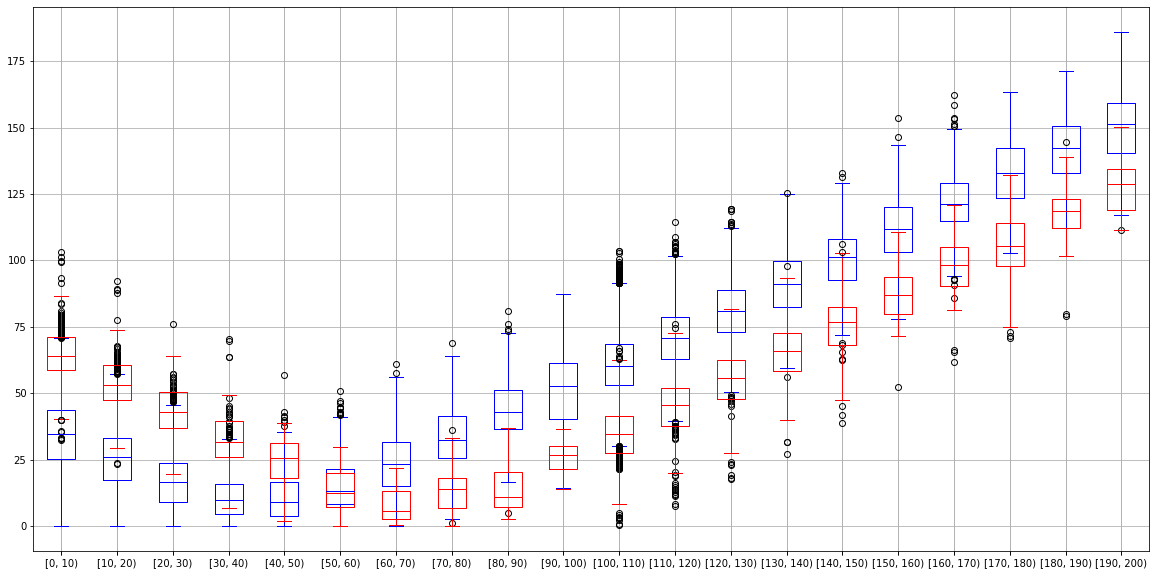

In [35]:
# 重回帰分析
df_compare_LR_error_under90.boxplot(figsize=(20,10), color='blue')
df_compare_LR_error_over90.boxplot(figsize=(20,10), color='red')

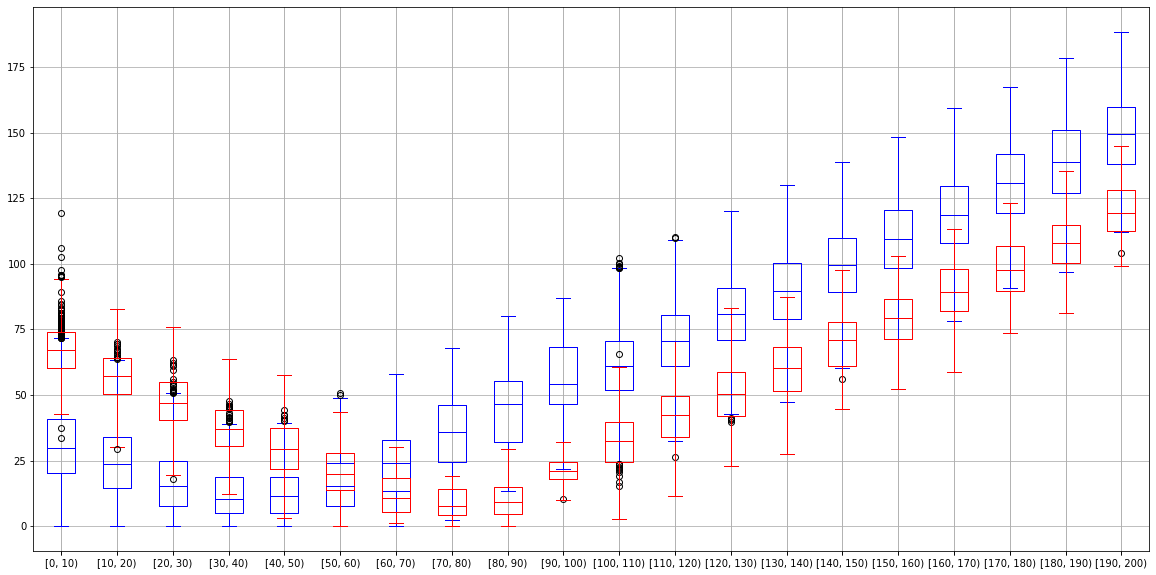

In [36]:
# ニューラルネットワーク
df_compare_MR_error_under90.boxplot(figsize=(20,10), color='blue')
df_compare_MR_error_over90.boxplot(figsize=(20,10), color='red')

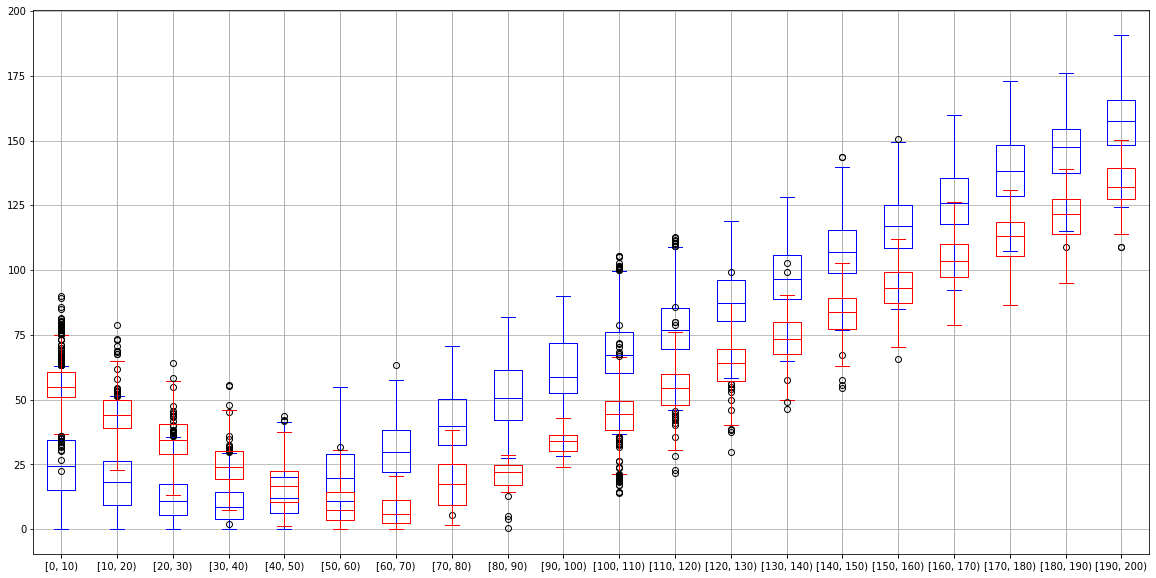

In [37]:
# 勾配ブースティング決定木
df_compare_XR_error_under90.boxplot(figsize=(20,10), color='blue')
df_compare_XR_error_over90.boxplot(figsize=(20,10), color='red')

### 考察
重回帰分析、ニューラルネットワーク、勾配ブースティング決定木を用いて回帰分析を行なった。  
また、目的変数を資金調達率90%未満と90%以上に分けて、それぞれモデルを学習させた。  

それぞれのけっかを描画したのが上図である。  
横軸は目的変数である資金調達率、縦軸は予測と正解の誤差の絶対値である。  
各モデルにおいて、学習データで学習した領域の方が誤差が低いことがわかった。  
「全量のデータで学習するより、資金調達率90%以上のデータのみで学習した方が、精度が上がるのではないか？」という仮説を基に検証してみたが、評価指標のみを見ると精度の差がないように感じられたが、このような比較をすることで、少し改善されたようにも見える。  

モデルの評価の仕方は、軸の取り方によって違うため、どの指標を見るべきかが難しいと感じた。  

### 方針１と方針２の結果を比較する

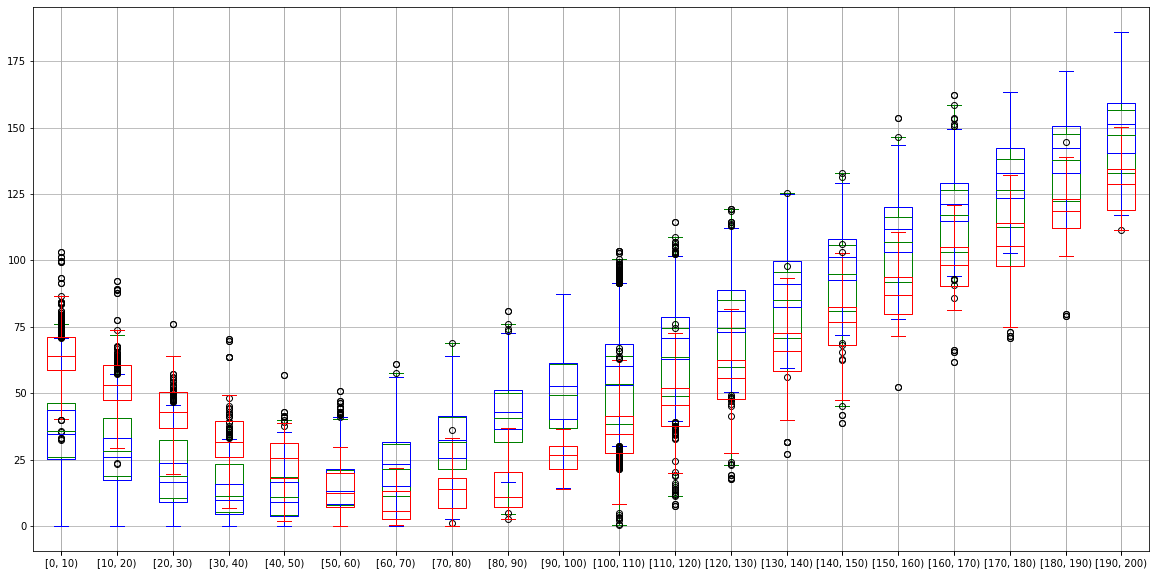

In [38]:
# 重回帰分析
df_compare_LR_error.boxplot(figsize=(20,10), color='green')
df_compare_LR_error_under90.boxplot(figsize=(20,10), color='blue')
df_compare_LR_error_over90.boxplot(figsize=(20,10), color='red')

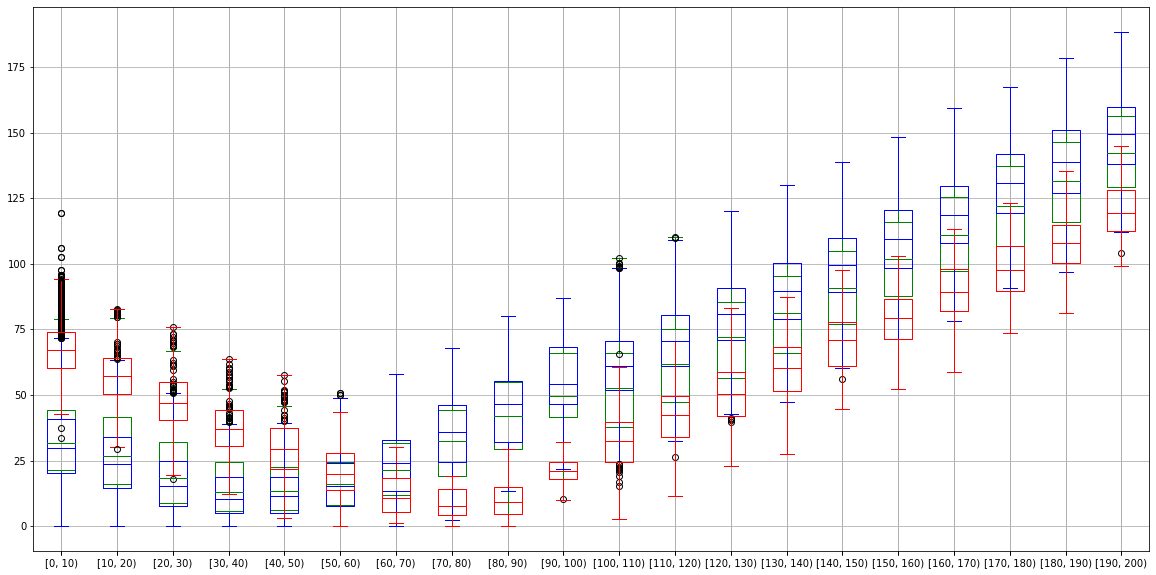

In [39]:
# ニューラルネットワーク
df_compare_MR_error.boxplot(figsize=(20,10), color='green')
df_compare_MR_error_under90.boxplot(figsize=(20,10), color='blue')
df_compare_MR_error_over90.boxplot(figsize=(20,10), color='red')

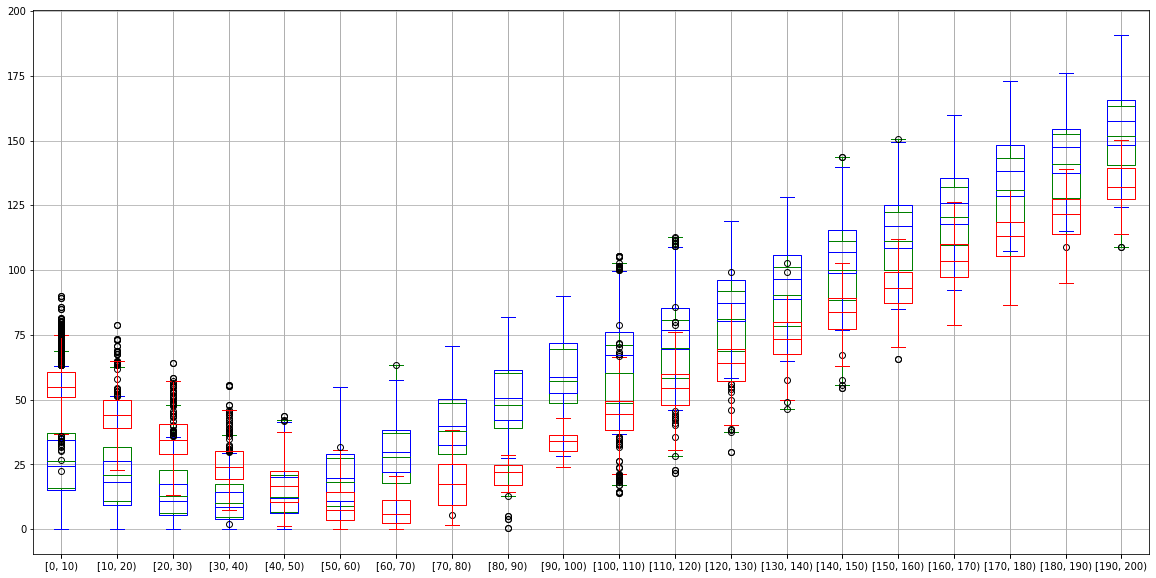

In [40]:
# 勾配ブースティング決定木
df_compare_XR_error.boxplot(figsize=(20,10), color='green')
df_compare_XR_error_under90.boxplot(figsize=(20,10), color='blue')
df_compare_XR_error_over90.boxplot(figsize=(20,10), color='red')

### 方針１と方針２を比較した結果
縦軸が誤差であるため、箱ひげ図が下にあるものが、x軸の資金調達率の範囲において一番誤差が低いモデルであることを示す。  
各モデルにおいて、90%未満は、90%未満用のモデル、90%以上は90%以上のモデルが誤差が低いことがわかった。  

### まとめ
kaggleのKickstarterを通して、前処理やモデルを多く学ぶことができた。  
また、方針２のように、自分で立てた仮説に対して、調べながらも最後まで実装することができる基礎力をこの講座を通して学ぶことができた。  
課題を通して、学習データの選定や、前処理は、様々な機械学習モデルの特徴や理論がわからないと、精度向上のためのチューニングができないことを痛感した。  
「なんとなくライブラリで予測を出す。」のハードルは低いが、実務で使えるレベルの精度を出すためには、モデルへの数学的深い理解が必要だと感じたため、今後も意識していきたい。  